# 🚀 Orbital Debris Collision Predictor — Pipeline Demo

**Author:** prince italiya  
**Project:** AIML Minor — Collision Predictor using TLE & SGP4

**Notebook purpose:**  
This Colab notebook demonstrates the full pipeline: TLE parsing → SGP4 propagation → KD-tree screening → analytic closest approach → feature generation → ML training (RF & XGBoost) → prediction & alerts → 3D visualization.

**Run order:** Execute cells sequentially from top to bottom. Use the sidebar to mount Google Drive if you want to persist models/data.


In [3]:
# Install required packages (Colab)
!pip install -q numpy pandas scipy sgp4 scikit-learn xgboost joblib streamlit plotly matplotlib

# Imports used across the notebook
import os
import math
import json
import shutil
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display, HTML
print("Setup complete. Python version info:")
import sys
print(sys.version)


Setup complete. Python version info:
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


## Data sources & notes

- This notebook expects either:
  - A precomputed `/content/positions.csv` (fast path), or
  - Raw TLE `.txt` files that you can parse and propagate.

**Paths used in demo** (change if needed):
- `positions.csv` (ECI states at epoch): `/content/positions.csv`
- intermediate files (will be created): `/content/candidate_pairs.csv`, `/content/features.csv`
- models: `/content/rf_model.joblib`, `/content/xgb_model.json`
- final predictions: `/content/predictions.csv` and `/content/alerts.csv`

If you have your project files locally, upload them in Colab left panel -> Files -> Upload, or mount Drive:
```python
from google.colab import drive
drive.mount('/content/drive')


In [4]:
POSITIONS_PATH = "/content/positions.csv"

if os.path.exists(POSITIONS_PATH):
    pos_df = pd.read_csv(POSITIONS_PATH)
    print("Loaded positions.csv:", POSITIONS_PATH, "rows =", len(pos_df))
    display(pos_df.head(5))
else:
    print("positions.csv not found at /content.")
    print("If you have TLE files, upload them and run parsing/propagation cells (below).")
    # Optional: sample generation (small synthetic dataset) for demo
    print("\nGenerating a tiny synthetic demo dataset (10 objects) for visualization/testing...")
    # Create a toy circular orbit positions (NOT realistic for production)
    names = [f"SAT_{i:02d}" for i in range(10)]
    rows = []
    for i,name in enumerate(names):
        theta = i * (2*math.pi/10)
        r = 6771.0  # km (LEO)
        x = r * math.cos(theta)
        y = r * math.sin(theta)
        z = 0.0
        vx = -7.5 * math.sin(theta)
        vy = 7.5 * math.cos(theta)
        vz = 0.0
        rows.append({"name": name, "rx_km": x, "ry_km": y, "rz_km": z, "vx_km_s": vx, "vy_km_s": vy, "vz_km_s": vz, "datetime_utc": datetime.utcnow().isoformat()})
    pos_df = pd.DataFrame(rows)
    pos_df.to_csv(POSITIONS_PATH, index=False)
    print("Sample positions saved to", POSITIONS_PATH)
    display(pos_df.head())


Loaded positions.csv: /content/positions.csv rows = 5000


,name,src_file,datetime_utc,rx_km,ry_km,rz_km,vx_km_s,vy_km_s,vz_km_s
0,CALSPHERE 1,active satellites.txt,2025-11-24T07:52:04.606108,-1051.785159,-2548.725258,6806.872083,-2.672980,-6.278471,-2.778877
1,CALSPHERE 2,active satellites.txt,2025-11-24T07:52:04.606108,-2020.443614,-5905.555665,4025.683364,-1.325841,-3.764213,-6.151114
2,LCS 1,active satellites.txt,2025-11-24T07:52:04.606108,-154.339084,8671.395845,2920.544655,-5.918040,0.848270,-2.810628
3,TEMPSAT 1,active satellites.txt,2025-11-24T07:52:04.606108,6081.795198,3901.778137,1957.151007,1.651998,1.061489,-7.042847
4,CALSPHERE 4A,active satellites.txt,2025-11-24T07:52:04.606108,-1943.861964,2857.438658,-6613.518628,-3.666098,5.344177,3.411823


In [5]:
# OPTIONAL: If you uploaded raw TLE files, parse them and propagate to create positions.csv.
# This cell uses the parse_tles + propagate logic from src/parse_tles.py & src/propagate.py.
# Paste your TLE file paths in tle_files list or upload them to /content first.

from sgp4.api import Satrec, jday

def parse_tle_text(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n\r") for ln in f.readlines() if ln.strip()]
    triples = []
    i = 0
    while i < len(lines):
        if i+2 < len(lines) and lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
            name = lines[i]; l1 = lines[i+1]; l2 = lines[i+2]; triples.append((name,l1,l2)); i+=3
        elif lines[i].startswith("1 ") and i+1 < len(lines) and lines[i+1].startswith("2 "):
            l1 = lines[i]; l2 = lines[i+1]
            norad = l1.split()[1] if len(l1.split())>1 else "UNK"
            triples.append((f"NORAD_{norad}", l1, l2)); i+=2
        else:
            i+=1
    return triples

def propagate_triples(triples, out_path="/content/positions.csv"):
    epoch = datetime.utcnow()
    jd, fr = jday(epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second + epoch.microsecond*1e-6)
    rows=[]
    for name,l1,l2 in triples:
        try:
            sat = Satrec.twoline2rv(l1, l2)
            err, r, v = sat.sgp4(jd, fr)
            if err==0:
                rows.append({"name": name, "datetime_utc": epoch.isoformat(), "rx_km": r[0], "ry_km": r[1], "rz_km": r[2], "vx_km_s": v[0], "vy_km_s": v[1], "vz_km_s": v[2]})
        except Exception as e:
            continue
    pd.DataFrame(rows).to_csv(out_path, index=False)
    print("Propagated", len(rows), "objects to", out_path)

# Example usage:
# tle_files = ["/content/active.txt", "/content/debris.txt"]
# triples=[]
# for fp in tle_files:
#     triples.extend(parse_tle_text(fp))
# propagate_triples(triples)


In [6]:

from scipy.spatial import cKDTree

CAND_OUT = "/content/candidate_pairs.csv"
SCREEN_RADIUS_M = 200_000.0  # 200 km default

coords = pos_df[['rx_km','ry_km','rz_km']].values
tree = cKDTree(coords)
pairs = tree.query_pairs(r=SCREEN_RADIUS_M/1000.0)
print("Found candidate pairs:", len(pairs))

rows=[]
for i,j in pairs:
    a=pos_df.iloc[i]; b=pos_df.iloc[j]
    rows.append({
        'i': int(i), 'j': int(j),
        'name_i': a['name'], 'name_j': b['name'],
        'rx_i_km': a['rx_km'], 'ry_i_km': a['ry_km'], 'rz_i_km': a['rz_km'],
        'rx_j_km': b['rx_km'], 'ry_j_km': b['ry_km'], 'rz_j_km': b['rz_km'],
        'vx_i_km_s': a['vx_km_s'], 'vy_i_km_s': a['vy_km_s'], 'vz_i_km_s': a['vz_km_s'],
        'vx_j_km_s': b['vx_km_s'], 'vy_j_km_s': b['vy_km_s'], 'vz_j_km_s': b['vz_km_s']
    })

cand_df = pd.DataFrame(rows)
cand_df.to_csv(CAND_OUT, index=False)
print("Saved candidate pairs:", CAND_OUT, "rows =", len(cand_df))
display(cand_df.head())


Found candidate pairs: 1550
Saved candidate pairs: /content/candidate_pairs.csv rows = 1550


,i,j,name_i,name_j,rx_i_km,ry_i_km,rz_i_km,rx_j_km,ry_j_km,rz_j_km,vx_i_km_s,vy_i_km_s,vz_i_km_s,vx_j_km_s,vy_j_km_s,vz_j_km_s
0,1921,3841,CMS-01,CMS-02 (GSAT 24),-3997.362200,-41941.353993,-12.927662,-4003.717417,-41955.985844,-9.079185,3.063214,-0.292154,-0.000072,3.062081,-0.292375,0.002232
1,2466,4049,STARLINK-2755,STARLINK-4133,3164.773138,2722.215094,5515.783508,3023.963056,2849.082408,5521.114621,-4.543054,6.070552,-0.387993,-4.807977,5.868030,-0.394058
2,1379,2883,STARLINK-1068,STARLINK-3079,2561.963753,3279.604640,5525.106233,2450.554618,3337.169318,5532.142229,-5.854880,4.831357,-0.152697,-6.040443,4.605016,-0.101996
3,499,735,ASTRA 2F,ASTRA 2G,-36597.629158,-20904.773344,-34.867603,-36612.094594,-20922.163492,-25.281608,1.526053,-2.670671,0.001261,1.525297,-2.669351,-0.002924
4,583,4935,POPACS 1,ASTROCAST-0403,-3473.269929,-3836.852118,-4434.017775,-3457.532269,-3790.171447,-4580.937546,-2.053916,-4.610661,5.676593,2.368134,4.589981,-5.584298


In [7]:
# Compute analytic closest approach features for each candidate pair
FEATURES_OUT = "/content/features.csv"
CA_WINDOW_S = 600.0
LABEL_THRESH_M = 1000.0

def analytic_closest_approach(r_rel_km, v_rel_km_s, window_s):
    v_dot_v = np.dot(v_rel_km_s, v_rel_km_s)
    if v_dot_v <= 1e-12:
        t_star = 0.0
    else:
        t_star = - np.dot(r_rel_km, v_rel_km_s) / v_dot_v
    t_star = max(-window_s, min(window_s, t_star))
    r_at_t = r_rel_km + v_rel_km_s * t_star
    min_dist_km = np.linalg.norm(r_at_t)
    return t_star, min_dist_km

feat_rows=[]
for _, row in cand_df.iterrows():
    r_rel_km = np.array([row['rx_j_km'] - row['rx_i_km'],
                         row['ry_j_km'] - row['ry_i_km'],
                         row['rz_j_km'] - row['rz_i_km']])
    v_rel_km_s = np.array([row['vx_j_km_s'] - row['vx_i_km_s'],
                           row['vy_j_km_s'] - row['vy_i_km_s'],
                           row['vz_j_km_s'] - row['vz_i_km_s']])
    t_star, min_dist_km = analytic_closest_approach(r_rel_km, v_rel_km_s, CA_WINDOW_S)
    min_dist_m = min_dist_km * 1000.0
    rel_speed_m_s = np.linalg.norm(v_rel_km_s) * 1000.0
    r_norm_m = np.linalg.norm(r_rel_km) * 1000.0
    if r_norm_m < 1e-9:
        closing_rate_m_s = 0.0
    else:
        closing_rate_m_s = np.dot(r_rel_km*1000.0, v_rel_km_s*1000.0) / r_norm_m
    label = 1 if min_dist_m < LABEL_THRESH_M else 0
    feat_rows.append({
        'i': int(row['i']), 'j': int(row['j']),
        'name_i': row['name_i'], 'name_j': row['name_j'],
        'min_dist_m': float(min_dist_m),
        'time_to_CA_s': float(t_star),
        'rel_speed_m_s': float(rel_speed_m_s),
        'closing_rate_m_s': float(closing_rate_m_s),
        'label': int(label)
    })

feat_df = pd.DataFrame(feat_rows)
feat_df.to_csv(FEATURES_OUT, index=False)
print("Saved features to:", FEATURES_OUT, "rows =", len(feat_df))
display(feat_df.describe())
print("Number of positives (label=1):", int(feat_df['label'].sum()))


Saved features to: /content/features.csv rows = 1550


,i,j,min_dist_m,time_to_CA_s,rel_speed_m_s,closing_rate_m_s,label
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,1961.359355,3333.514839,110037.471105,-5.966363,4713.395449,27.233016,0.003871
std,1067.573008,1222.662100,48729.565021,250.230767,5077.437533,4205.706258,0.062117
min,3.000000,201.000000,0.000000,-600.000000,0.000000,-13911.144256,0.000000
25%,1216.750000,2613.500000,72758.462898,-35.342113,267.487678,-914.180958,0.000000
50%,1920.000000,3658.500000,110073.568270,-0.271624,2464.496945,0.094697,0.000000
75%,2553.000000,4273.000000,151364.341382,22.687278,9122.743396,566.780655,0.000000
max,4992.000000,4998.000000,199150.644230,600.000000,15199.144928,14659.402226,1.000000


Number of positives (label=1): 6


In [8]:
# DAY-3: Train RandomForest and XGBoost (uses features.csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import xgboost as xgb

FEATURES_IN = FEATURES_OUT
df = pd.read_csv(FEATURES_IN)
X = df[["min_dist_m","rel_speed_m_s","closing_rate_m_s","time_to_CA_s"]]
y = df["label"]
# small-sample safeguard
if len(df) < 10:
    print("Very small dataset — skipping training. Use a larger dataset for training.")
else:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    classes = np.array([0,1])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    cw = {0: weights[0], 1: weights[1]}
    print("Class weights:", cw)
    rf = RandomForestClassifier(n_estimators=200, class_weight=cw, random_state=42)
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_val)[:,1]
    print("RF ROC-AUC:", roc_auc_score(y_val, rf_probs))
    print("RF PR-AUC :", average_precision_score(y_val, rf_probs))
    joblib.dump(rf, "/content/rf_model.joblib")
    print("Saved RF model -> /content/rf_model.joblib")
    # XGBoost
    if len(np.unique(y)) > 1:
        xgbm = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.7, colsample_bytree=0.7, use_label_encoder=False, eval_metric='logloss')
        xgbm.fit(X_train, y_train)
        xgb_probs = xgbm.predict_proba(X_val)[:,1]
        print("XGB ROC-AUC:", roc_auc_score(y_val, xgb_probs))
        print("XGB PR-AUC :", average_precision_score(y_val, xgb_probs))
        xgbm.save_model("/content/xgb_model.json")
        print("Saved XGB model -> /content/xgb_model.json")
    else:
        print("Not enough positive samples for XGBoost training.")


Class weights: {0: np.float64(0.5019430051813472), 1: np.float64(129.16666666666666)}
RF ROC-AUC: 1.0
RF PR-AUC : 1.0
Saved RF model -> /content/rf_model.joblib


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:41:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB ROC-AUC: 0.9844559585492229
XGB PR-AUC : 0.5714285714285714
Saved XGB model -> /content/xgb_model.json


In [9]:
# DAY-4: Run inference and create alerts
import joblib
FEATURES_IN = "/content/features.csv"
OUT_PRED = "/content/predictions.csv"
OUT_ALERT = "/content/alerts.csv"
ALERT_THRESHOLD = 0.5

df = pd.read_csv(FEATURES_IN)
X = df[["min_dist_m","rel_speed_m_s","closing_rate_m_s","time_to_CA_s"]].fillna(0.0).values

probs = {}
if os.path.exists("/content/rf_model.joblib"):
    rf = joblib.load("/content/rf_model.joblib")
    probs['rf'] = rf.predict_proba(X)[:,1]
    print("Loaded RF")
if os.path.exists("/content/xgb_model.json"):
    xgbm = xgb.XGBClassifier()
    xgbm.load_model("/content/xgb_model.json")
    probs['xgb'] = xgbm.predict_proba(X)[:,1]
    print("Loaded XGB")

if not probs:
    raise SystemExit("No models found. Run training or upload models to /content.")

df['prob_ensemble'] = np.mean(np.vstack(list(probs.values())), axis=0)
df.to_csv(OUT_PRED, index=False)
print("Saved predictions ->", OUT_PRED)

# Alerts
alerts = df[df['prob_ensemble'] >= ALERT_THRESHOLD].sort_values(['prob_ensemble','min_dist_m'], ascending=[False, True])
alerts.to_csv(OUT_ALERT, index=False)
print("Saved alerts ->", OUT_ALERT)
print("Alerts count:", len(alerts))
display(alerts.head(20))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Loaded RF
Loaded XGB
Saved predictions -> /content/predictions.csv
Saved alerts -> /content/alerts.csv
Alerts count: 5


,i,j,name_i,name_j,min_dist_m,time_to_CA_s,rel_speed_m_s,closing_rate_m_s,label,prob_ensemble
1062,688,1096,O3B FM7,O3B FM13,41.575695,600.000000,0.013995,-0.013339,1,0.797976
467,221,353,TERRASAR-X,TANDEM-X,551.297988,600.000000,0.424680,-0.262875,1,0.754298
634,4038,4718,CSS (WENTIAN),CSS (MENGTIAN),0.000000,0.000000,0.000000,0.000000,1,0.740131
33,2684,2685,TIANHUI 2-02A,TIANHUI 2-02B,404.407171,384.681195,0.556504,-0.260361,1,0.704298
1536,1300,1301,TIANHUI 2-01A,TIANHUI 2-01B,357.706963,-600.000000,0.635824,0.501718,1,0.598762


Top pair: O3B FM7 <-> O3B FM13 prob: 0.7979763758182525


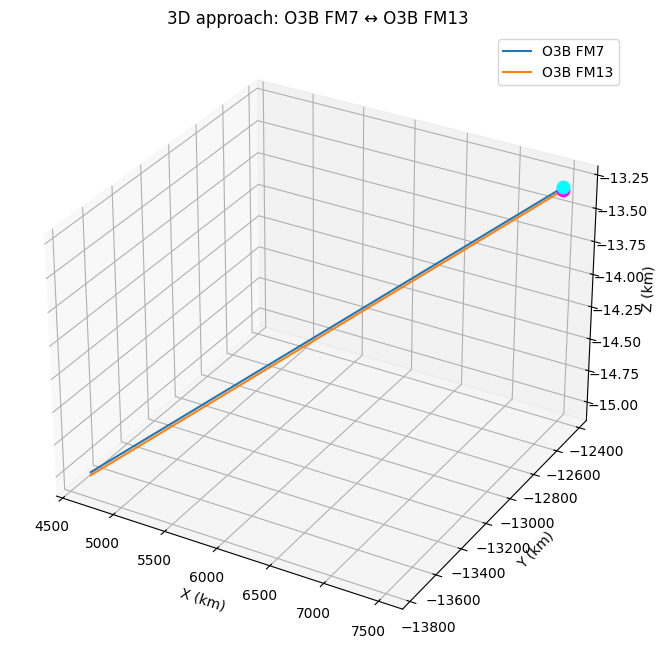

In [10]:
# 3D visualization of top predicted pair (if any)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

PRED_PATH = "/content/predictions.csv"
POS_PATH = "/content/positions.csv"

pred = pd.read_csv(PRED_PATH)
if pred.empty:
    print("No predictions available.")
else:
    top = pred.sort_values(['prob_ensemble','min_dist_m'], ascending=[False, True]).iloc[0]
    name_i = top['name_i']; name_j = top['name_j']
    print("Top pair:", name_i, "<->", name_j, "prob:", top['prob_ensemble'])
    pos = pd.read_csv(POS_PATH)
    try:
        a = pos[pos['name']==name_i].iloc[0]
        b = pos[pos['name']==name_j].iloc[0]
        # For visualization, propagate small window around epoch using current state linear extrapolation
        times = np.linspace(-300,300,61)  # seconds
        xi = a['rx_km'] + a['vx_km_s'] * times
        yi = a['ry_km'] + a['vy_km_s'] * times
        zi = a['rz_km'] + a['vz_km_s'] * times
        xj = b['rx_km'] + b['vx_km_s'] * times
        yj = b['ry_km'] + b['vy_km_s'] * times
        zj = b['rz_km'] + b['vz_km_s'] * times

        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(xi, yi, zi, label=name_i)
        ax.plot(xj, yj, zj, label=name_j)
        # closest point
        dists = np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
        mi = np.argmin(dists)
        ax.scatter([xi[mi]],[yi[mi]],[zi[mi]], color='cyan', s=80)
        ax.scatter([xj[mi]],[yj[mi]],[zj[mi]], color='magenta', s=80)
        ax.plot([xi[mi], xj[mi]],[yi[mi], yj[mi]],[zi[mi], zj[mi]], color='green')
        ax.set_xlabel("X (km)"); ax.set_ylabel("Y (km)"); ax.set_zlabel("Z (km)")
        ax.legend()
        ax.set_title(f"3D approach: {name_i} ↔ {name_j}")
        plt.show()
    except Exception as e:
        print("Could not find positions for pair in positions.csv. Exception:", e)


## Evaluation discussion

- Use ROC-AUC and PR-AUC for imbalanced datasets.
- For real-world reliability add Monte-Carlo with TLE uncertainty (future work).
- Here we print the metrics if we have validation split during training.


# If you ran training above, you may have printed the metrics.
# If you want to compute metrics on features and saved models now, load models and compute on a holdout split (not implemented here).


In [11]:
# Download predictions & alerts from Colab (if running here)
from google.colab import files
for path in ["/content/predictions.csv", "/content/alerts.csv", "/content/rf_model.joblib", "/content/xgb_model.json"]:
    if os.path.exists(path):
        print("Preparing download:", path)
        files.download(path)
    else:
        print("Missing, not downloading:", path)


Preparing download: /content/predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing download: /content/alerts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing download: /content/rf_model.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing download: /content/xgb_model.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Next steps (recommended)

- Add Monte-Carlo uncertainty propagation for more robust probability estimation.
- Add covariance matrices and track state uncertainty (like NASA/ESA pipelines).
- Deploy the Streamlit app (src/app_streamlit.py) using Render / Heroku or Docker for live demo.
- Add Telegram/Discord alerts for live notifications.

**That’s it — the full pipeline demo.**  
If you need, I can convert these cells into a ready `.ipynb` file and provide it for download — tell me and I'll prepare that for you.
